Ankita      
MDS202309

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Unzip sentimentdata.zip
import zipfile
import os

zip_path = "/content/drive/MyDrive/sentimentdata.zip"  # Update if path differs
extract_path = "/content/sentimentdata"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
# 3. Load train and test CSV files
import pandas as pd

train_df = pd.read_csv(os.path.join(extract_path, "data/train.csv"), encoding='iso-8859-1')
test_df = pd.read_csv(os.path.join(extract_path, "data/test.csv"), encoding='iso-8859-1')

train_df = train_df[['text', 'sentiment']]
test_df = test_df[['text', 'sentiment']]


In [9]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [11]:
# 4. Encode sentiment labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['label'] = label_encoder.transform(test_df['sentiment'])

<ipython-input-11-6a0bf1d3f1ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = label_encoder.fit_transform(train_df['sentiment'])


In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [14]:
# 5. Load tokenizer and model
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [19]:
# 6. Fine-tune BERT model

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Freeze all layers except the last 2 encoder layers and the classifier
freeze_until = -2  # Set to -1 to unfreeze only the last layer, -2 for last two, etc.

for name, param in model.bert.named_parameters():
    if not any([f"encoder.layer.{i}." in name for i in range(11 + freeze_until + 1, 12)]):  # BERT has 12 layers
        param.requires_grad = False

# Always keep classifier head trainable
for param in model.classifier.parameters():
    param.requires_grad = True



training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to = "none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.688000,0.559443
2,0.481100,0.567603
3,0.505200,0.557144


TrainOutput(global_step=10305, training_loss=0.5900489044559633, metrics={'train_runtime': 3570.1197, 'train_samples_per_second': 23.092, 'train_steps_per_second': 2.886, 'total_flos': 2.169107015749632e+16, 'train_loss': 0.5900489044559633, 'epoch': 3.0})

In [20]:
# 7. Evaluate the model
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

print("Classification Report:\n")
print(classification_report(test_df['label'], preds, target_names=label_encoder.classes_))

Classification Report:

              precision    recall  f1-score   support

    negative       0.75      0.81      0.78      1001
     neutral       0.75      0.74      0.74      1430
    positive       0.84      0.81      0.83      1103

    accuracy                           0.78      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.78      0.78      0.78      3534



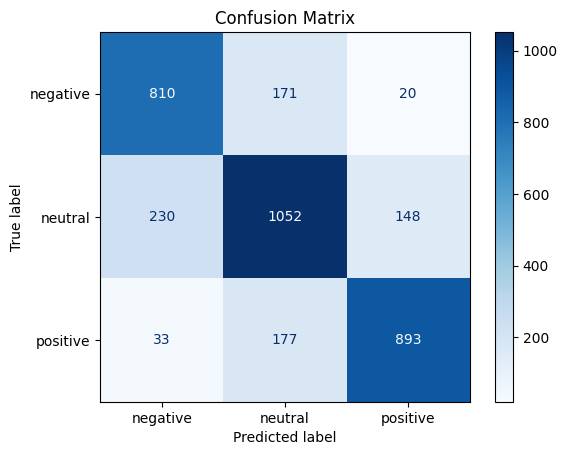

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_df['label'], preds)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
